# Creating a data quality flag

This tutorial explains how to use data from an auxiliary channel to identify time periods likely to contain loud bursts of excess power in LIGO strain data. These bursts are generally called "glitches."

The LIGO-Virgo-KAGRA collaboration uses code similar to that introduced in this tutorial to make the data quality (DQ) flags used in their analyses. Note that each type of data quality flag uses a different auxiliary channel and analysis methods. You can find more details about data quality flags in the following publications: 

* [O3 Data Quality Vetoes Technical Note](https://dcc.ligo.org/LIGO-T2100045/public)
* [O3 LIGO Detector Characterization Publication](https://arxiv.org/abs/2101.11673)

## Get data

This DQ flag is generated using the `L1:PEM-EY_MIC_VEA_PLUSY_DQ` channel, a microphone located at the Y-end of LIGO Livingston. Let's also download the strain data from the same time for later use. 

In [1]:
from gwpy.timeseries import TimeSeries

thunder_gps = 1244750468

data_window = 512
data_start = thunder_gps - data_window
data_end = thunder_gps + data_window

In [2]:
strain_data = TimeSeries.fetch('L1:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01_AR', 
                        start=data_start, end=data_end, host='losc-nds.ligo.org').resample(4096)

In [3]:
aux_data = TimeSeries.fetch('L1:PEM-EY_MIC_VEA_PLUSY_DQ', 
                        start=data_start, end=data_end, host='losc-nds.ligo.org').resample(4096)

## Analyze data and create the flag

A standard method to identify time periods of excess noise is calculating a channel's *band-limited root-mean-square* (BLRMS). In this case, we will focus on the bandwidth of 10-100 Hz and calculate the RMS of the data every 1 second. 

In [4]:
flower = 10
fupper = 100
step = 1
threshold = 250

In [5]:
aux_blrms = aux_data.bandpass(flower, fupper, fstop=[flower/2., fupper*1.5], 
                              filtfilt=False, ftype='butter').crop(
                              aux_data.times.value[0]+3, aux_data.times.value[-1]-3).rms(step)

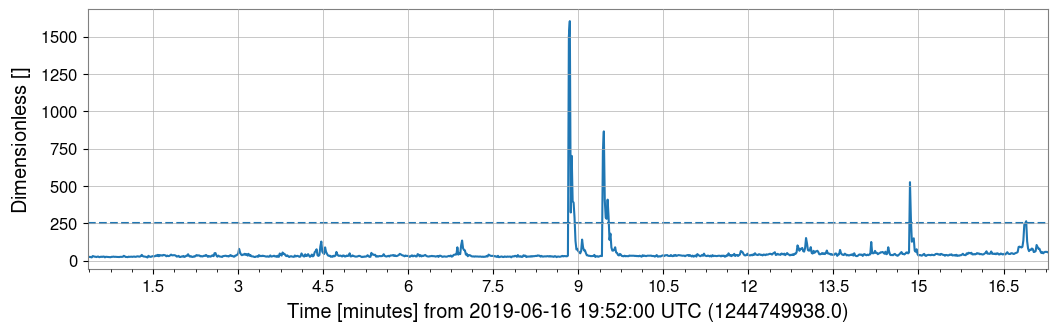

In [6]:
plot = aux_blrms.plot()
ax = plot.gca()
ax.axhline(threshold, ls='--')
plot.show()

When we plot the data, we can see a few times where there are large spikes in the BLRMS of the data. Let's pick a threshold that captures most of these spikes and then find all the times where the BLRMS is above this chosen threshold. 

We can then make a *flag* that contains a list of all these times. 

In [7]:
from gwpy.segments import DataQualityFlag, Segment, SegmentList

# find times above threshold
times = aux_blrms.times[aux_blrms.value > threshold]

# put in to segment list and coalesce
segs = SegmentList()
segs.extend([Segment(int(t.value), int(t.value)+step) for t in times])
segs = segs.coalesce()

# set up the xml file
start_time = []
start_time.extend([t[0] for t in segs])
end_time = []
end_time.extend([t[1] for t in segs])

flag_name = 'L1:DCH-EY_MIC_BP_GT_250:1'

# put in to dq flag
flag = DataQualityFlag(flag_name, 
                       active=zip(start_time,end_time), 
                       known=[[data_start,data_end]])


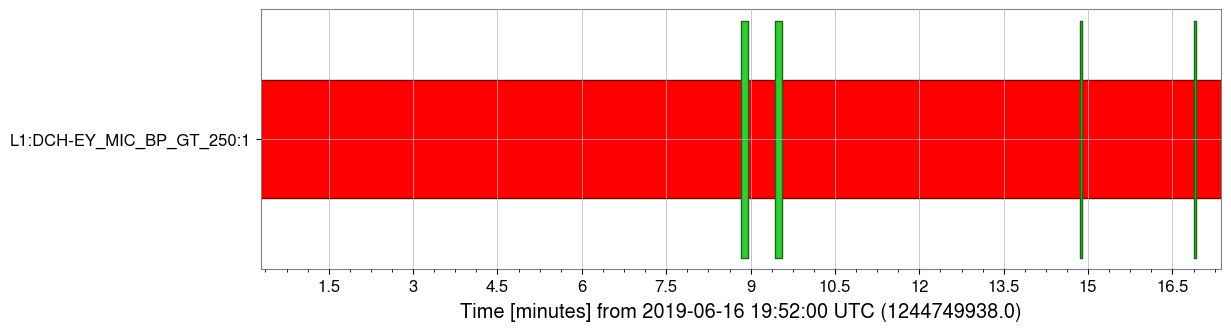

In [8]:
flag.plot().show()

## Visualizing the results

Let's now check what happens in the strain data during the time periods we've flagged. First, we will make a spectrogram of the strain data and then add a bar at the bottom showing the flag we generated. We can see that during the times we flagged, there is lots of excess noise in our strain data!

In [9]:
plot_window = 32

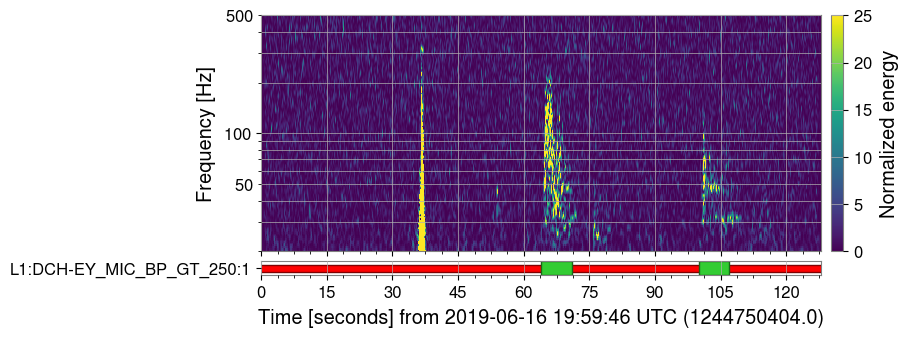

In [10]:
strain_data_crop = strain_data.crop(thunder_gps-2*plot_window, thunder_gps+2*plot_window)
qspecgram_strain = strain_data_crop.q_transform(qrange=(30,40), frange=(20, 500), 
                                                outseg=(thunder_gps-2*plot_window, 
                                                        thunder_gps+2*plot_window))

plot = qspecgram_strain.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0,25])
ax.set_xlim(thunder_gps-2*plot_window, thunder_gps+2*plot_window)
plot.add_segments_bar(flag)
plot.show()

In this case, the noise is caused by thunder. Microphones located around the site are excellent witnesses of this type of noise. However, there appears to be another glitch (near 35 seconds in the spectrogram) that isn't captured by our data quality flag! Let's investigate this a bit further. 

We should now check our microphone data to see how that noise compares to what's in the strain data.

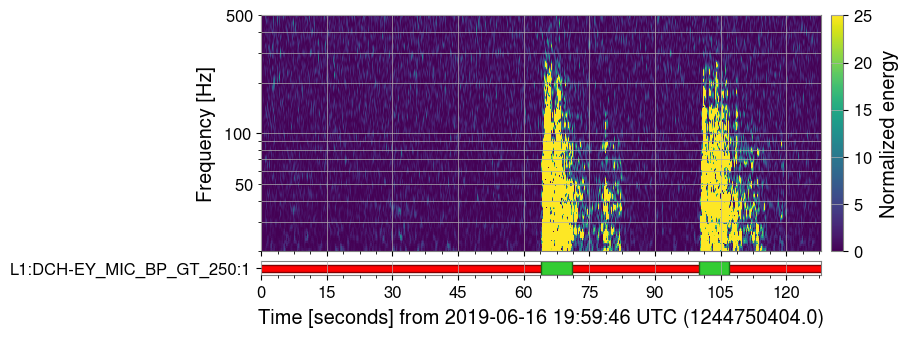

In [11]:
aux_data_crop = aux_data.crop(thunder_gps-2*plot_window, thunder_gps+2*plot_window)
qspecgram_aux = aux_data_crop.q_transform(qrange=(30,40), frange=(20, 500), 
                                          outseg=(thunder_gps-2*plot_window, 
                                                  thunder_gps+2*plot_window))

plot = qspecgram_aux.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0,25])
ax.set_xlim(thunder_gps-2*plot_window, thunder_gps+2*plot_window)
plot.add_segments_bar(flag)
plot.show()

As we can see, the noise in the microphone is very similar to the noise in the strain data during the times that we veto! We don't see any noise in our microphone simultaneously as the other glitch (near 35 seconds) we noticed in the strain data. This suggests that there is a different source of the glitch than what our microphones can measure. 

Seeing multiple glitches with different sources in the same data is a common occurrence. To thoroughly investigate this other glitch, we would need to check other auxiliary channels to see if there are any other explanations. However, many glitches (even common ones!) don't yet have an identified source. The specific glitch in this spectrogram is one of those classes of glitches. We call glitches similar to this one "tomte" glitches. Active investigation into tomte glitches is still ongoing!